In [ ]:
# # Install necessary libraries
# !pip install torch torchvision
# !pip install opencv-python-headless
# !pip install numpy
# !pip install pycocotools
# !pip install fiftyone

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
from torch.cuda.amp import autocast, GradScaler

class SeatbeltDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.seatbelt_images = [f for f in os.listdir(os.path.join(root_dir, 'Seatbelt_updataset/Seatbelt')) if f.endswith('.jpg')]
        self.noseatbelt_images = [f for f in os.listdir(os.path.join(root_dir, 'Seatbelt_updataset/NoSeatbelt')) if f.endswith('.jpg')]
        self.all_images = self.seatbelt_images + self.noseatbelt_images

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_name = self.all_images[idx]
        if 'NoSeatBelt' in img_name:
            img_path = os.path.join(self.root_dir, 'Seatbelt_updataset/NoSeatbelt', img_name)
            mask_path = os.path.join(self.root_dir, 'Seatbelt_updataset/MaskedNoSeatBelt', 'mask_' + img_name)
            label = 0  # no seatbelt
        else:
            img_path = os.path.join(self.root_dir, 'Seatbelt_updataset/Seatbelt', img_name)
            mask_path = os.path.join(self.root_dir, 'Seatbelt_updataset/MaskedSeatBelt', 'mask_' + img_name)
            label = 1  # seatbelt

        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found or cannot be read: {img_path}")
        mask = cv2.imread(mask_path, 0)
        if mask is None:
            raise FileNotFoundError(f"Mask not found or cannot be read: {mask_path}")

        # Convert to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Convert to PIL Image for transformation
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)

        if self.transform:
            image = self.transform(image)
            mask = T.ToTensor()(mask)  # Convert mask to tensor separately

        return image, mask, label

def collate_fn(batch):
    return tuple(zip(*batch))

transform = T.Compose([
    T.ToTensor()
])

dataset = SeatbeltDataset(root_dir='/content/drive/MyDrive/SeatBelt_mask_data/', transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [3]:
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn

# Load pre-trained Mask R-CNN model
model = maskrcnn_resnet50_fpn(pretrained=True)

# Modify the classifier for the new number of classes
num_classes = 3  # background, seatbelt, no seatbelt

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 86.4MB/s]


In [4]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)

# Assuming `model` is already defined
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer and learning rate
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Mixed precision training setup
scaler = GradScaler()

# Gradient accumulation steps
accumulation_steps = 4

# Train the model
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    optimizer.zero_grad()  # Reset gradients at the start of every epoch
    for i, (images, masks, labels) in enumerate(dataloader):
        try:
            images = [image.to(device) for image in images]
            targets = []
            for mask, label in zip(masks, labels):
                d = {}
                d['boxes'] = torch.tensor([[0, 0, mask.shape[2], mask.shape[1]]], dtype=torch.float32).to(device)
                d['labels'] = torch.tensor([label], dtype=torch.int64).to(device)
                d['masks'] = mask.unsqueeze(0).to(device)
                targets.append(d)

            with autocast():
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

            scaler.scale(losses).backward()

            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            epoch_loss += losses.item()
        except Exception as e:
            print(f"Error in epoch {epoch}, batch {i}: {e}")
            raise e  # Re-raise exception to stop training and debug

    lr_scheduler.step()
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')

torch.save(model.state_dict(), '/content/drive/MyDrive/SeatBelt_mask_data/Seatbelt_updataset/mask_rcnn_seatbelt.pth')

Epoch 1, Loss: nan
Epoch 2, Loss: nan
Epoch 3, Loss: nan
Epoch 4, Loss: nan
Epoch 5, Loss: nan
Epoch 6, Loss: nan
Epoch 7, Loss: nan
Epoch 8, Loss: nan
Epoch 9, Loss: nan
Epoch 10, Loss: nan
Epoch 11, Loss: nan
Epoch 12, Loss: nan
Epoch 13, Loss: nan
Epoch 14, Loss: nan
Epoch 15, Loss: nan
Epoch 16, Loss: nan
Epoch 17, Loss: nan
Epoch 18, Loss: nan
Epoch 19, Loss: nan
Epoch 20, Loss: nan
Epoch 21, Loss: nan
Epoch 22, Loss: nan
Epoch 23, Loss: nan
Epoch 24, Loss: nan
Epoch 25, Loss: nan


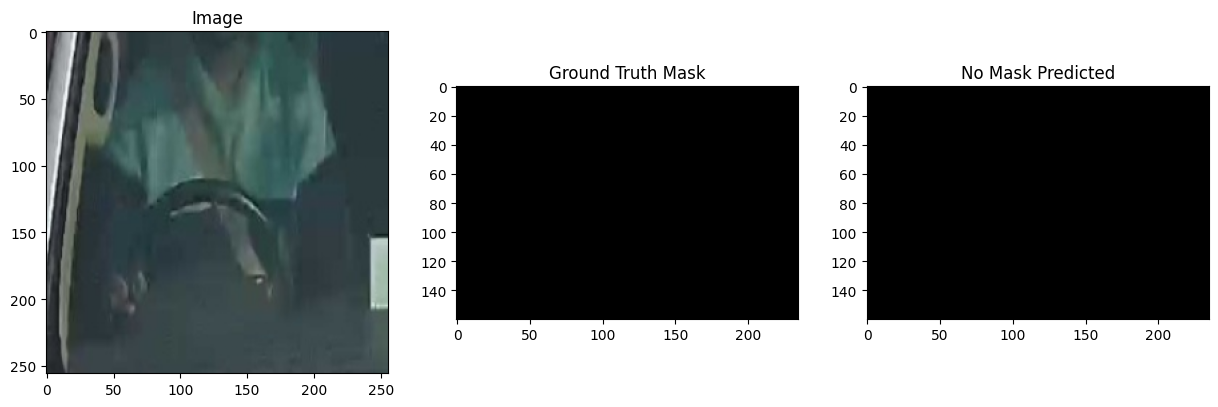

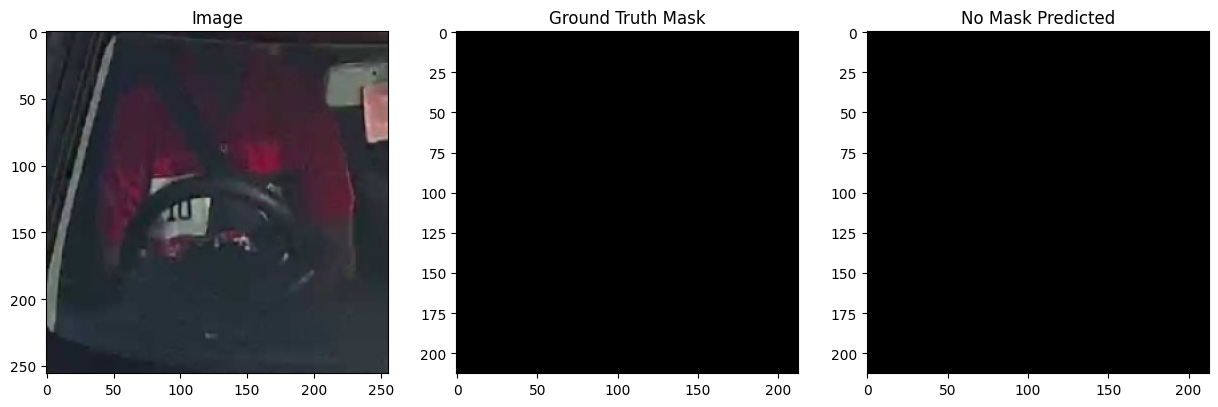

In [16]:
import os
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class SeatbeltDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.root_dir, img_name)
        mask_name = 'mask_' + img_name.split('__')[-1]
        mask_path = os.path.join(self.root_dir, mask_name)

        if 'NoSeatBelt' in img_name:
            label = 0  # no seatbelt
        else:
            label = 1  # seatbelt

        image = Image.open(img_path).convert("RGB")

        if os.path.exists(mask_path):
            mask = Image.open(mask_path).convert("L")
        else:
            # Creating a placeholder mask if the mask does not exist
            mask = Image.new("L", image.size)

        if self.transform:
            image = self.transform(image)
            mask = T.ToTensor()(mask)  # Convert mask to tensor separately

        return image, mask, label

# Define a function to visualize the results
def visualize_results(images, masks, predictions):
    for i in range(len(images)):
        image = images[i].permute(1, 2, 0).cpu().numpy()
        mask = masks[i].squeeze().cpu().numpy()

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title('Image')

        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Ground Truth Mask')

        if len(predictions[i]['masks']) > 0:
            pred_mask = predictions[i]['masks'][0, 0].cpu().numpy()
            label = predictions[i]['labels'][0].cpu().numpy()
            plt.subplot(1, 3, 3)
            plt.imshow(pred_mask, cmap='gray')
            plt.title(f'Predicted Mask (Label: {label})')
        else:
            plt.subplot(1, 3, 3)
            plt.imshow(np.zeros_like(mask), cmap='gray')
            plt.title('No Mask Predicted')

        plt.show()

# Custom collate function to handle varying image and mask sizes
def custom_collate_fn(batch):
    images = [item[0] for item in batch]
    masks = [item[1] for item in batch]
    labels = [item[2] for item in batch]
    return images, masks, labels

# Define the transform with resizing
transform = T.Compose([
    T.Resize((256, 256)),  # Resize all images to 256x256
    T.ToTensor()
])

# Load the trained model
model.load_state_dict(torch.load('/content/drive/MyDrive/SeatBelt_mask_data/Seatbelt_updataset/mask_rcnn_seatbelt.pth'))
model.to(device)
model.eval()

# Prepare the test dataset
test_dataset = SeatbeltDataset('/content/drive/MyDrive/SeatBelt_project/DATA/testing', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=custom_collate_fn)

# Run the model on a batch of test images
images, masks, labels = next(iter(test_dataloader))
images = [image.to(device) for image in images]
targets = []
for mask, label in zip(masks, labels):
    d = {}
    d['boxes'] = torch.tensor([[0, 0, mask.shape[1], mask.shape[0]]], dtype=torch.float32).to(device)
    d['labels'] = torch.tensor([label], dtype=torch.int64).to(device)
    d['masks'] = mask.unsqueeze(0).to(device)
    targets.append(d)

with torch.no_grad():
    predictions = model(images)

# Visualize the results
visualize_results(images, masks, predictions)

In [5]:
# import os
# from PIL import Image
# import cv2
# import torch
# from torch.utils.data import Dataset, DataLoader
# import torchvision.transforms as T

# class SeatbeltDataset(Dataset):
#     def __init__(self, root_dir, transform=None):
#         self.root_dir = root_dir
#         self.transform = transform
#         self.seatbelt_images = [f for f in os.listdir(os.path.join(root_dir, 'Seatbelt_updataset/Seatbelt')) if f.endswith('.jpg')]
#         self.noseatbelt_images = [f for f in os.listdir(os.path.join(root_dir, 'Seatbelt_updataset/NoSeatbelt')) if f.endswith('.jpg')]
#         self.all_images = self.seatbelt_images + self.noseatbelt_images

#     def __len__(self):
#         return len(self.all_images)

#     def __getitem__(self, idx):
#         img_name = self.all_images[idx]
#         if 'NoSeatBelt' in img_name:
#             img_path = os.path.join(self.root_dir, 'Seatbelt_updataset/NoSeatbelt', img_name)
#             mask_path = os.path.join(self.root_dir, 'Seatbelt_updataset/MaskedNoSeatBelt', 'mask_' + img_name)
#             label = 0  # no seatbelt
#         else:
#             img_path = os.path.join(self.root_dir, 'Seatbelt_updataset/Seatbelt', img_name)
#             mask_path = os.path.join(self.root_dir, 'Seatbelt_updataset/MaskedSeatBelt', 'mask_' + img_name)
#             label = 1  # seatbelt

#         image = cv2.imread(img_path)
#         if image is None:
#             raise FileNotFoundError(f"Image not found or cannot be read: {img_path}")
#         mask = cv2.imread(mask_path, 0)
#         if mask is None:
#             raise FileNotFoundError(f"Mask not found or cannot be read: {mask_path}")

#         # Convert to RGB
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         # Convert to PIL Image for transformation
#         image = Image.fromarray(image)
#         mask = Image.fromarray(mask)

#         if self.transform:
#             image = self.transform(image)
#             mask = T.ToTensor()(mask)  # Convert mask to tensor separately

#         return image, mask, label

# def collate_fn(batch):
#     images, masks, labels = zip(*batch)
#     return list(images), list(masks), list(labels)

# transform = T.Compose([
#     T.ToTensor()
# ])

# dataset = SeatbeltDataset(root_dir='/content/drive/MyDrive/SeatBelt_mask_data/', transform=transform)
# dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4, collate_fn=collate_fn)


In [6]:
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn

# Load pre-trained Mask R-CNN model
model = maskrcnn_resnet50_fpn(pretrained=True)

# Modify the classifier for the new number of classes
num_classes = 3  # background, seatbelt, no seatbelt

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

In [ ]:
import torch
import torch.optim as optim

# Assuming `model` is already defined
# Define optimizer and learning rate
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Define learning rate scheduler
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Train the model
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for i, (images, masks, labels) in enumerate(dataloader):
        try:
            images = list(image for image in images)
            targets = []
            for mask, label in zip(masks, labels):
                d = {}
                d['boxes'] = torch.tensor([[0, 0, mask.shape[2], mask.shape[1]]], dtype=torch.float32)
                d['labels'] = torch.tensor([label], dtype=torch.int64)
                d['masks'] = mask.unsqueeze(0)
                targets.append(d)

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()
            epoch_loss += losses.item()
        except Exception as e:
            print(f"Error in epoch {epoch}, batch {i}: {e}")
            raise e  # Re-raise exception to stop training and debug

    lr_scheduler.step()
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')

# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/SeatBelt_mask_data/Seatbelt_updataset/mask_rcnn_seatbelt.pth')

In [ ]:
import matplotlib.pyplot as plt

# Load the model
model.load_state_dict(torch.load('/content/drive/MyDrive/mask_rcnn_seatbelt.pth'))
model.eval()

# Load a sample image
image, _, _ = dataset[0]
with torch.no_grad():
    prediction = model([image])

# Visualize the results
plt.figure(figsize=(10,10))
plt.imshow(image.permute(1, 2, 0))
plt.title("Predicted Mask")
plt.imshow(prediction[0]['masks'][0, 0].cpu(), alpha=0.5)
plt.show()